#### Importing the Required Lib

In [1]:
import gym
import numpy as np
import networkx as nx
import random
import pandas as pd
from gym import spaces
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Enviornment: Network Env

In [2]:
class NetworkEnvironment(gym.Env):
    def __init__(self, data, num_nodes=6):
        super(NetworkEnvironment, self).__init__()

        # Loading the dataset and initializing the network topology which is ring in this case 
        self.data = data
        self.num_nodes = num_nodes
        self.graph = nx.cycle_graph(num_nodes)
        
        # Defining the source and sink nodes aka destination node 
        self.source_node = 0
        self.sink_node = num_nodes - 1

        # Edge keys in traffic load
        self.traffic_load = {}
        for edge in self.graph.edges:
            standardized_edge = (min(edge[0], edge[1]), max(edge[0], edge[1]))
            self.traffic_load[standardized_edge] = 0  # Initial load set to 0
            
            # defining the Edge properties
            self.graph.edges[edge]["latency"] = random.uniform(1, 5)  # Latency in seconds
            self.graph.edges[edge]["capacity"] = random.randint(1, 10)  # Capacity in packets/second

        # State space and the action space
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Modified for additional state info
        self.action_space = spaces.Discrete(len(list(self.graph.neighbors(self.source_node))))

        # Initializing
        self.current_node = self.source_node
        self.assign_traffic_intensities()

        self.episode = 0
        self.total_reward = 0
        self.epsilon = 1.0  
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def assign_traffic_intensities(self):
        # Assigning the traffic intensity
        for node in self.graph.nodes:
            self.graph.nodes[node]["traffic_intensity"] = 0

        for _, row in self.data.iterrows():
            src_ip, dest_ip = row['SourceIP'], row['DestinationIP']
            bytes_sent = row['BytesSent']
            # Mapping the IDs to the nodes
            src_node = int(src_ip) % self.num_nodes
            dest_node = int(dest_ip) % self.num_nodes
            
            # Accumulating the  traffic intensity on source and destination node
            self.graph.nodes[src_node]["traffic_intensity"] += bytes_sent
            self.graph.nodes[dest_node]["traffic_intensity"] += bytes_sent

    def update_traffic_load(self):
        #adding the random fluctuations in traffic load
        for edge in self.traffic_load:
            self.traffic_load[edge] = max(0, self.traffic_load[edge] + random.randint(-1, 2)) 

    def get_state(self):
        traffic_intensity = self.graph.nodes[self.current_node]["traffic_intensity"] / (
            max(node["traffic_intensity"] for node in self.graph.nodes.values()) + 1e-6)
        max_adjacent_load = max(
            self.traffic_load[(min(self.current_node, neighbor), max(self.current_node, neighbor))]
            for neighbor in self.graph.neighbors(self.current_node)
        ) / (max(self.traffic_load.values()) + 1e-6)
        # Calculating normalized distance
        distance_to_sink = nx.shortest_path_length(self.graph, source=self.current_node, target=self.sink_node) / self.num_nodes
        return np.array([self.current_node / self.num_nodes, traffic_intensity, max_adjacent_load, distance_to_sink])

    def calculate_reward(self, edge, next_node):
        load = self.traffic_load[edge]
        capacity = self.graph.edges[edge]["capacity"]
        latency = self.graph.edges[edge]["latency"]
        load_penalty = load / (capacity + 1e-6) 

        reward = -latency * (1 + load_penalty)  # Penalty proportional to load
        if next_node == self.sink_node:
            reward += 100.0  # Success reward
        return reward

    def step(self, action):
        neighbors = list(self.graph.neighbors(self.current_node))
        next_node = neighbors[action]
        
        # Updating the traffic load 
        standardized_edge = (min(self.current_node, next_node), max(self.current_node, next_node))

        # Checking if load exceeds the capacity
        if self.traffic_load[standardized_edge] >= self.graph.edges[standardized_edge]["capacity"]:
            done = True 
            reward = -10.0  
            return self.get_state(), reward, done, {}
        self.traffic_load[standardized_edge] += 1  

        # Calculation of the reward based on latency and load
        reward = self.calculate_reward(standardized_edge, next_node)
        
        step_penalty = -1  # step penalty 
        reward += step_penalty
        
        # Updating the total reward
        self.total_reward += reward

        self.current_node = next_node
        done = self.current_node == self.sink_node

        # Updating the traffic dynamically
        self.update_traffic_load()

        return self.get_state(), reward, done, {}

    def reset(self):
        # RESET
        self.current_node = self.source_node
        self.total_reward = 0 
        self.episode += 1  

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        for edge in self.traffic_load:
            self.traffic_load[edge] = 0
        self.assign_traffic_intensities()
        return self.get_state()

    def render(self, mode='human'):
        # Function for rendering the environment
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.graph, seed=42)  # Positions of the nodes

        # Node color based on traffic intensity
        node_colors = [
            self.graph.nodes[node]["traffic_intensity"] / (max(nx.get_node_attributes(self.graph, "traffic_intensity").values()) + 1e-6)
            for node in self.graph.nodes
        ]
        nx.draw_networkx_nodes(self.graph, pos, node_size=500, node_color=node_colors, cmap="coolwarm")
        
        # Drawing the edges which represents traffic load
        edge_colors = []
        edge_labels = {}
        for edge in self.graph.edges:
            standardized_edge = (min(edge[0], edge[1]), max(edge[0], edge[1]))
            load = self.traffic_load[standardized_edge]
            edge_colors.append('red' if load > 0 else 'black')  # Red if traffic, black otherwise 
            edge_labels[edge] = f"Load: {load}"

        nx.draw_networkx_edges(self.graph, pos, edge_color=edge_colors, width=2)
        nx.draw_networkx_labels(self.graph, pos, font_size=12, font_color="black")
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=10)

        plt.title(f"Episode: {self.episode}, Total Reward: {self.total_reward:.2f}, Epsilon: {self.epsilon:.3f}, Current Node: {self.current_node}")
        plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), label="Node Traffic Intensity")
        plt.show()

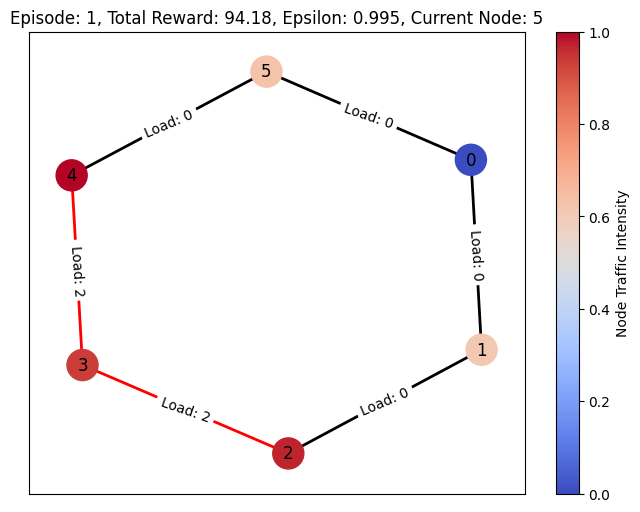

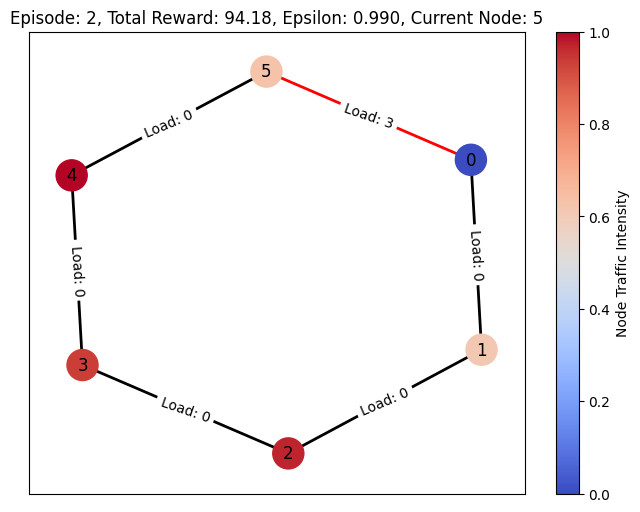

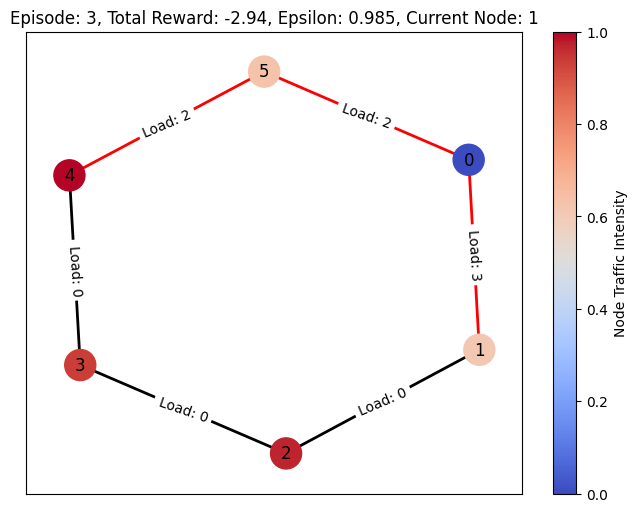

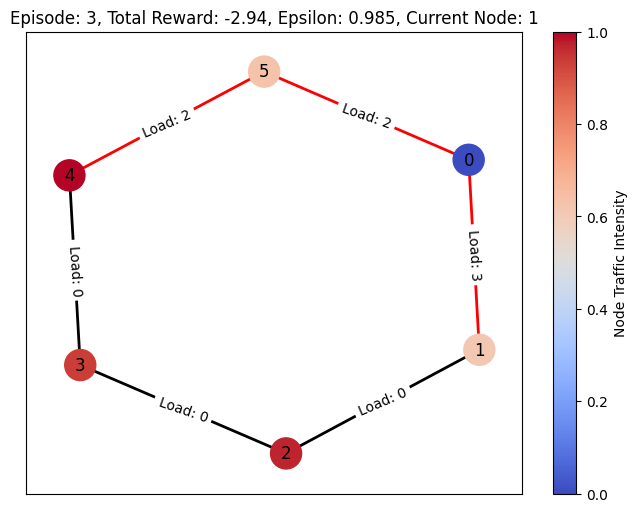

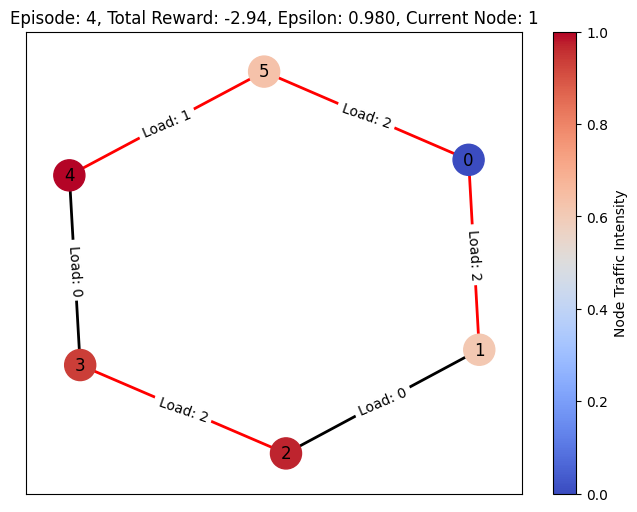

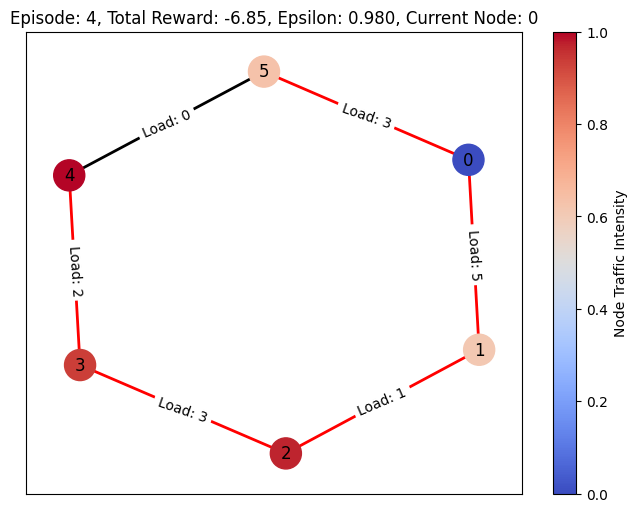

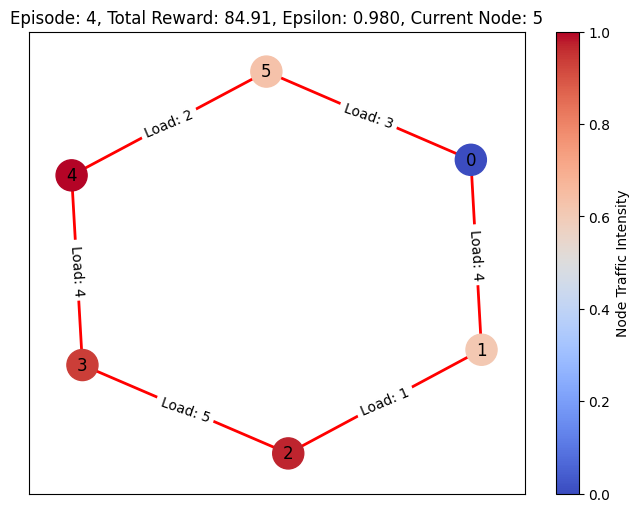

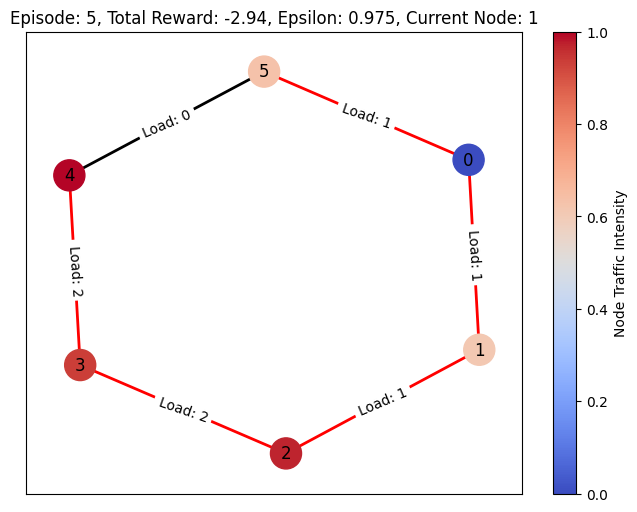

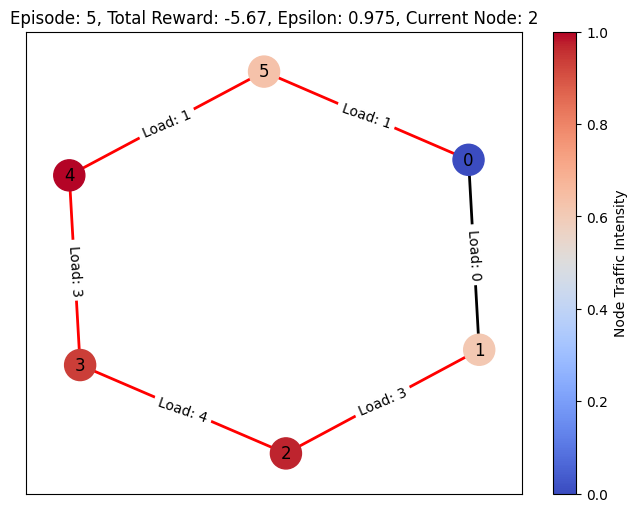

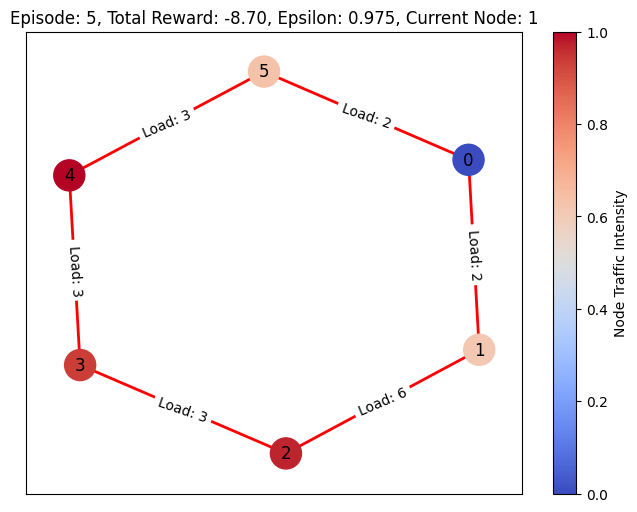

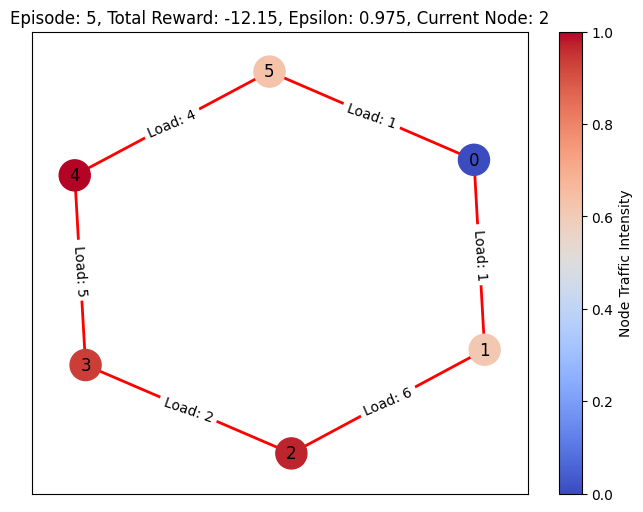

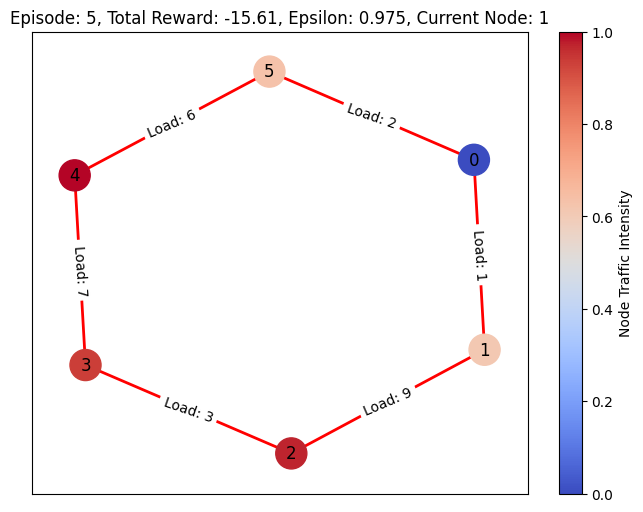

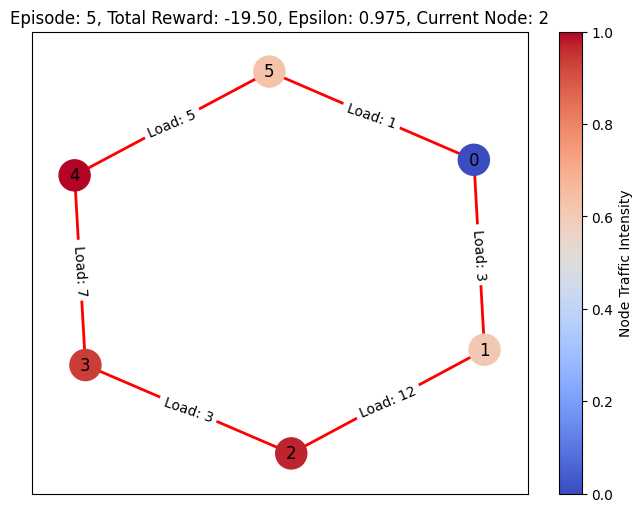

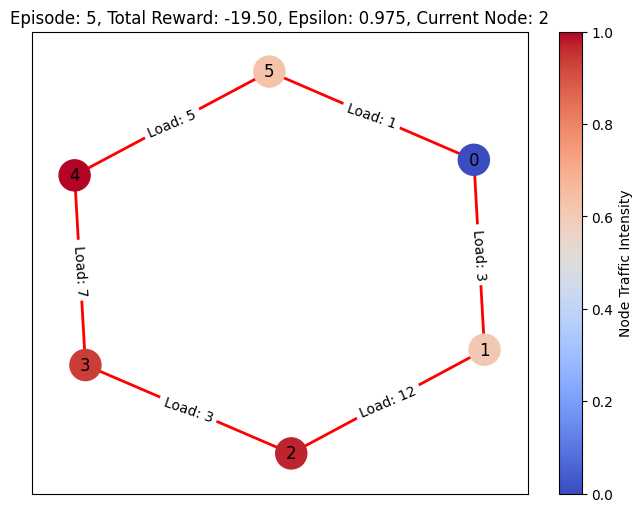

In [3]:
# Stimulating and ensuring the proper functionality of the env , rendering it as well 
# As we have defined the num_nodes to be 6 in the env  , hence 6 nodes will be present in our network 

# Loading of the dataset and initializing the environment
data = pd.read_csv('/Users/krishnanand/Documents/Git/synthetic_network_traffic.csv')
env = NetworkEnvironment(data)
episodes = 5  # for test purpose we have chosen the test episodes to be 5

# episodes
for episode in range(episodes):
    state = env.reset()
    done = False

    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        env.render()
        if done:
            break

### Q Learning

/var/folders/xg/nnfc0_t10qj8w9hggkw8ss5h0000gn/T/ipykernel_37636/2673402356.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


Episode 1/1500, Total Reward: -25.78, Epsilon: 0.999
Episode 2/1500, Total Reward: -19.31, Epsilon: 0.998
Episode 3/1500, Total Reward: 95.89, Epsilon: 0.997
Episode 4/1500, Total Reward: -19.31, Epsilon: 0.996
Episode 5/1500, Total Reward: -42.73, Epsilon: 0.995
Episode 6/1500, Total Reward: -19.31, Epsilon: 0.994
Episode 7/1500, Total Reward: 95.89, Epsilon: 0.993
Episode 8/1500, Total Reward: 76.42, Epsilon: 0.992
Episode 9/1500, Total Reward: 95.89, Epsilon: 0.991
Episode 10/1500, Total Reward: -38.08, Epsilon: 0.990
Episode 11/1500, Total Reward: 95.89, Epsilon: 0.989
Episode 12/1500, Total Reward: 95.89, Epsilon: 0.988
Episode 13/1500, Total Reward: -25.40, Epsilon: 0.987
Episode 14/1500, Total Reward: 95.89, Epsilon: 0.986
Episode 15/1500, Total Reward: -34.48, Epsilon: 0.985
Episode 16/1500, Total Reward: -48.88, Epsilon: 0.984
Episode 17/1500, Total Reward: 95.89, Epsilon: 0.983
Episode 18/1500, Total Reward: -25.59, Epsilon: 0.982
Episode 19/1500, Total Reward: -43.00, Epsilo

Episode 154/1500, Total Reward: 95.89, Epsilon: 0.857
Episode 155/1500, Total Reward: 95.89, Epsilon: 0.856
Episode 156/1500, Total Reward: 95.89, Epsilon: 0.855
Episode 157/1500, Total Reward: 67.83, Epsilon: 0.855
Episode 158/1500, Total Reward: 95.89, Epsilon: 0.854
Episode 159/1500, Total Reward: -54.78, Epsilon: 0.853
Episode 160/1500, Total Reward: 95.89, Epsilon: 0.852
Episode 161/1500, Total Reward: -19.31, Epsilon: 0.851
Episode 162/1500, Total Reward: 95.89, Epsilon: 0.850
Episode 163/1500, Total Reward: -19.31, Epsilon: 0.850
Episode 164/1500, Total Reward: -19.31, Epsilon: 0.849
Episode 165/1500, Total Reward: 95.89, Epsilon: 0.848
Episode 166/1500, Total Reward: 95.89, Epsilon: 0.847
Episode 167/1500, Total Reward: 95.89, Epsilon: 0.846
Episode 168/1500, Total Reward: -28.61, Epsilon: 0.845
Episode 169/1500, Total Reward: 95.89, Epsilon: 0.844
Episode 170/1500, Total Reward: 95.89, Epsilon: 0.844
Episode 171/1500, Total Reward: 95.89, Epsilon: 0.843
Episode 172/1500, Total

Episode 305/1500, Total Reward: -35.11, Epsilon: 0.737
Episode 306/1500, Total Reward: 95.89, Epsilon: 0.736
Episode 307/1500, Total Reward: 95.89, Epsilon: 0.736
Episode 308/1500, Total Reward: 95.89, Epsilon: 0.735
Episode 309/1500, Total Reward: 95.89, Epsilon: 0.734
Episode 310/1500, Total Reward: -33.92, Epsilon: 0.733
Episode 311/1500, Total Reward: -30.04, Epsilon: 0.733
Episode 312/1500, Total Reward: 95.89, Epsilon: 0.732
Episode 313/1500, Total Reward: 95.89, Epsilon: 0.731
Episode 314/1500, Total Reward: -25.40, Epsilon: 0.730
Episode 315/1500, Total Reward: 95.89, Epsilon: 0.730
Episode 316/1500, Total Reward: 68.40, Epsilon: 0.729
Episode 317/1500, Total Reward: 95.89, Epsilon: 0.728
Episode 318/1500, Total Reward: 95.89, Epsilon: 0.727
Episode 319/1500, Total Reward: -38.12, Epsilon: 0.727
Episode 320/1500, Total Reward: 95.89, Epsilon: 0.726
Episode 321/1500, Total Reward: 95.89, Epsilon: 0.725
Episode 322/1500, Total Reward: 95.89, Epsilon: 0.725
Episode 323/1500, Total

Episode 457/1500, Total Reward: 95.89, Epsilon: 0.633
Episode 458/1500, Total Reward: 95.89, Epsilon: 0.632
Episode 459/1500, Total Reward: -34.92, Epsilon: 0.632
Episode 460/1500, Total Reward: 95.89, Epsilon: 0.631
Episode 461/1500, Total Reward: 95.89, Epsilon: 0.631
Episode 462/1500, Total Reward: 95.89, Epsilon: 0.630
Episode 463/1500, Total Reward: 95.89, Epsilon: 0.629
Episode 464/1500, Total Reward: 66.05, Epsilon: 0.629
Episode 465/1500, Total Reward: 95.89, Epsilon: 0.628
Episode 466/1500, Total Reward: 95.89, Epsilon: 0.627
Episode 467/1500, Total Reward: 95.89, Epsilon: 0.627
Episode 468/1500, Total Reward: 95.89, Epsilon: 0.626
Episode 469/1500, Total Reward: 95.89, Epsilon: 0.625
Episode 470/1500, Total Reward: 95.89, Epsilon: 0.625
Episode 471/1500, Total Reward: 95.89, Epsilon: 0.624
Episode 472/1500, Total Reward: 95.89, Epsilon: 0.624
Episode 473/1500, Total Reward: 95.89, Epsilon: 0.623
Episode 474/1500, Total Reward: 95.89, Epsilon: 0.622
Episode 475/1500, Total Rew

Episode 609/1500, Total Reward: -19.31, Epsilon: 0.544
Episode 610/1500, Total Reward: -22.54, Epsilon: 0.543
Episode 611/1500, Total Reward: 95.89, Epsilon: 0.543
Episode 612/1500, Total Reward: 95.89, Epsilon: 0.542
Episode 613/1500, Total Reward: -30.04, Epsilon: 0.542
Episode 614/1500, Total Reward: 95.89, Epsilon: 0.541
Episode 615/1500, Total Reward: 95.89, Epsilon: 0.540
Episode 616/1500, Total Reward: 95.89, Epsilon: 0.540
Episode 617/1500, Total Reward: 95.89, Epsilon: 0.539
Episode 618/1500, Total Reward: 95.89, Epsilon: 0.539
Episode 619/1500, Total Reward: 67.29, Epsilon: 0.538
Episode 620/1500, Total Reward: 95.89, Epsilon: 0.538
Episode 621/1500, Total Reward: 95.89, Epsilon: 0.537
Episode 622/1500, Total Reward: 95.89, Epsilon: 0.537
Episode 623/1500, Total Reward: -52.83, Epsilon: 0.536
Episode 624/1500, Total Reward: -34.28, Epsilon: 0.536
Episode 625/1500, Total Reward: 95.89, Epsilon: 0.535
Episode 626/1500, Total Reward: 68.24, Epsilon: 0.535
Episode 627/1500, Total

Episode 761/1500, Total Reward: 95.89, Epsilon: 0.467
Episode 762/1500, Total Reward: 55.94, Epsilon: 0.467
Episode 763/1500, Total Reward: 95.89, Epsilon: 0.466
Episode 764/1500, Total Reward: 95.89, Epsilon: 0.466
Episode 765/1500, Total Reward: 95.89, Epsilon: 0.465
Episode 766/1500, Total Reward: 95.89, Epsilon: 0.465
Episode 767/1500, Total Reward: 95.89, Epsilon: 0.464
Episode 768/1500, Total Reward: 95.89, Epsilon: 0.464
Episode 769/1500, Total Reward: 95.89, Epsilon: 0.463
Episode 770/1500, Total Reward: -30.13, Epsilon: 0.463
Episode 771/1500, Total Reward: 95.89, Epsilon: 0.462
Episode 772/1500, Total Reward: 95.89, Epsilon: 0.462
Episode 773/1500, Total Reward: 95.89, Epsilon: 0.461
Episode 774/1500, Total Reward: 95.89, Epsilon: 0.461
Episode 775/1500, Total Reward: 95.89, Epsilon: 0.461
Episode 776/1500, Total Reward: 95.89, Epsilon: 0.460
Episode 777/1500, Total Reward: 95.89, Epsilon: 0.460
Episode 778/1500, Total Reward: 95.89, Epsilon: 0.459
Episode 779/1500, Total Rew

Episode 913/1500, Total Reward: 95.89, Epsilon: 0.401
Episode 914/1500, Total Reward: -44.09, Epsilon: 0.401
Episode 915/1500, Total Reward: 95.89, Epsilon: 0.400
Episode 916/1500, Total Reward: 95.89, Epsilon: 0.400
Episode 917/1500, Total Reward: 95.89, Epsilon: 0.400
Episode 918/1500, Total Reward: 95.89, Epsilon: 0.399
Episode 919/1500, Total Reward: 95.89, Epsilon: 0.399
Episode 920/1500, Total Reward: 95.89, Epsilon: 0.398
Episode 921/1500, Total Reward: 95.89, Epsilon: 0.398
Episode 922/1500, Total Reward: 95.89, Epsilon: 0.398
Episode 923/1500, Total Reward: 95.89, Epsilon: 0.397
Episode 924/1500, Total Reward: 95.89, Epsilon: 0.397
Episode 925/1500, Total Reward: 95.89, Epsilon: 0.396
Episode 926/1500, Total Reward: -45.74, Epsilon: 0.396
Episode 927/1500, Total Reward: 95.89, Epsilon: 0.396
Episode 928/1500, Total Reward: 95.89, Epsilon: 0.395
Episode 929/1500, Total Reward: 95.89, Epsilon: 0.395
Episode 930/1500, Total Reward: 95.89, Epsilon: 0.394
Episode 931/1500, Total Re

Episode 1064/1500, Total Reward: 95.89, Epsilon: 0.345
Episode 1065/1500, Total Reward: 95.89, Epsilon: 0.345
Episode 1066/1500, Total Reward: 95.89, Epsilon: 0.344
Episode 1067/1500, Total Reward: 95.89, Epsilon: 0.344
Episode 1068/1500, Total Reward: 95.89, Epsilon: 0.344
Episode 1069/1500, Total Reward: 95.89, Epsilon: 0.343
Episode 1070/1500, Total Reward: 95.89, Epsilon: 0.343
Episode 1071/1500, Total Reward: 95.89, Epsilon: 0.342
Episode 1072/1500, Total Reward: 95.89, Epsilon: 0.342
Episode 1073/1500, Total Reward: 95.89, Epsilon: 0.342
Episode 1074/1500, Total Reward: 95.89, Epsilon: 0.341
Episode 1075/1500, Total Reward: 95.89, Epsilon: 0.341
Episode 1076/1500, Total Reward: 95.89, Epsilon: 0.341
Episode 1077/1500, Total Reward: 95.89, Epsilon: 0.340
Episode 1078/1500, Total Reward: 95.89, Epsilon: 0.340
Episode 1079/1500, Total Reward: -22.36, Epsilon: 0.340
Episode 1080/1500, Total Reward: 64.85, Epsilon: 0.339
Episode 1081/1500, Total Reward: 95.89, Epsilon: 0.339
Episode 1

Episode 1213/1500, Total Reward: 95.89, Epsilon: 0.297
Episode 1214/1500, Total Reward: 95.89, Epsilon: 0.297
Episode 1215/1500, Total Reward: 95.89, Epsilon: 0.297
Episode 1216/1500, Total Reward: 95.89, Epsilon: 0.296
Episode 1217/1500, Total Reward: 95.89, Epsilon: 0.296
Episode 1218/1500, Total Reward: 95.89, Epsilon: 0.296
Episode 1219/1500, Total Reward: 95.89, Epsilon: 0.295
Episode 1220/1500, Total Reward: 95.89, Epsilon: 0.295
Episode 1221/1500, Total Reward: 95.89, Epsilon: 0.295
Episode 1222/1500, Total Reward: 95.89, Epsilon: 0.294
Episode 1223/1500, Total Reward: 95.89, Epsilon: 0.294
Episode 1224/1500, Total Reward: 95.89, Epsilon: 0.294
Episode 1225/1500, Total Reward: 95.89, Epsilon: 0.294
Episode 1226/1500, Total Reward: -38.76, Epsilon: 0.293
Episode 1227/1500, Total Reward: -32.15, Epsilon: 0.293
Episode 1228/1500, Total Reward: 95.89, Epsilon: 0.293
Episode 1229/1500, Total Reward: 95.89, Epsilon: 0.292
Episode 1230/1500, Total Reward: -39.40, Epsilon: 0.292
Episode

Episode 1362/1500, Total Reward: -52.23, Epsilon: 0.256
Episode 1363/1500, Total Reward: 95.89, Epsilon: 0.256
Episode 1364/1500, Total Reward: 95.89, Epsilon: 0.255
Episode 1365/1500, Total Reward: 95.89, Epsilon: 0.255
Episode 1366/1500, Total Reward: 95.89, Epsilon: 0.255
Episode 1367/1500, Total Reward: 95.89, Epsilon: 0.255
Episode 1368/1500, Total Reward: 95.89, Epsilon: 0.254
Episode 1369/1500, Total Reward: 95.89, Epsilon: 0.254
Episode 1370/1500, Total Reward: 95.89, Epsilon: 0.254
Episode 1371/1500, Total Reward: 95.89, Epsilon: 0.254
Episode 1372/1500, Total Reward: 95.89, Epsilon: 0.253
Episode 1373/1500, Total Reward: 95.89, Epsilon: 0.253
Episode 1374/1500, Total Reward: 95.89, Epsilon: 0.253
Episode 1375/1500, Total Reward: 95.89, Epsilon: 0.253
Episode 1376/1500, Total Reward: 95.89, Epsilon: 0.252
Episode 1377/1500, Total Reward: 95.89, Epsilon: 0.252
Episode 1378/1500, Total Reward: -19.31, Epsilon: 0.252
Episode 1379/1500, Total Reward: 95.89, Epsilon: 0.252
Episode 

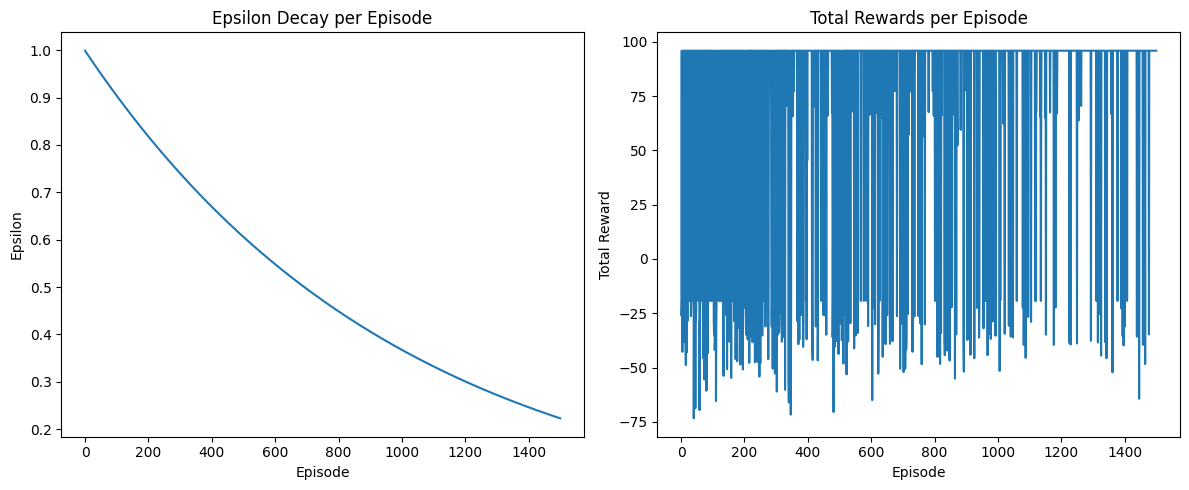

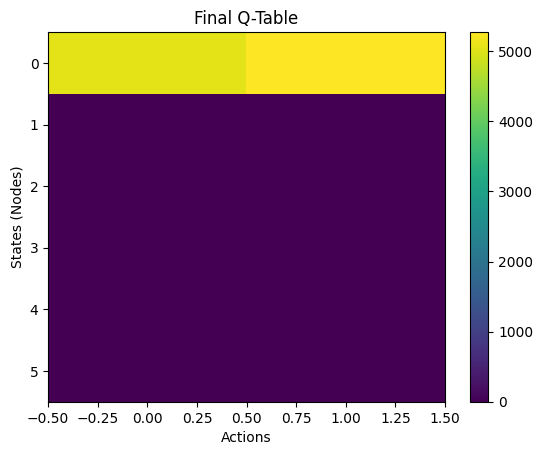

In [4]:
# As we are using Mac with ARM Chips , hence involving the MPS for faster computation 
device = torch.device("mps") if torch.has_mps else torch.device("cpu")

# Defining the Q-learning agent 
class QLearningAgent:
    def __init__(self, num_states, num_actions, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate  
        self.discount_factor = discount_factor  
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = torch.zeros((num_states, num_actions), device=device)

    def choose_action(self, state):
        # The Epsilon-greedy action
        if torch.rand(1).item() <= self.epsilon:
            return torch.randint(0, self.num_actions, (1,)).item()
        return torch.argmax(self.q_table[state]).item()

    def learn(self, state, action, reward, next_state):
        best_next_action = torch.argmax(self.q_table[next_state]).item()
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

# loading the dataset for involving the dynamic traffic 
data = pd.read_csv('/Users/krishnanand/Documents/Git/synthetic_network_traffic.csv') 
env = NetworkEnvironment(data)

# Definining the state and action size ( gave same as mentioned in the env )
num_states = env.num_nodes
num_actions = env.action_space.n

# Initializing the Q-learning agent
agent = QLearningAgent(num_states=num_states, num_actions=num_actions)
episodes = 1500
max_steps = 200
epsilon_values = []
total_rewards = []

# Training 
for episode in range(episodes):
    state = env.reset()
    state_index = int(state[0])  
    total_reward = 0
    done = False

    for step in range(max_steps):
        # Choosing the actions on the basis of  epsilon-greedy policy
        action = agent.choose_action(state_index)
    
        next_state, reward, done, _ = env.step(action)
        next_state_index = int(next_state[0])
        
        # Updating Q-table
        agent.learn(state_index, action, reward, next_state_index)
        
        state_index = next_state_index
        total_reward += reward
        
        if done:
            break

    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    
    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

# We cannot standerdize the Q table coz , few metrices will remain same bit few will be done according to algos in later section.
# Plotting the  epsilon decay
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title("Epsilon Decay per Episode")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

# Plotting total rewards per episode
plt.subplot(1, 2, 2)
plt.plot(total_rewards)
plt.title("Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.tight_layout()
plt.show()

# Visualizing Q-Table
plt.figure()
plt.imshow(agent.q_table.cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Final Q-Table")
plt.xlabel("Actions")
plt.ylabel("States (Nodes)")
plt.show()

#### Single Agent - Evaluation for Q-Learning 


Quantitative Evaluation Phase with Greedy Actions Only:
Episode 1/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 2/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 3/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 4/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 5/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 6/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 7/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 8/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 9/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01
Episode 10/10, Total Reward (Greedy): 95.89, Average Latency: 95.89, Throughput: 0.01

Summary of Quantitative Results (Greedy Actions Only):
Average Latency across episodes: 95.

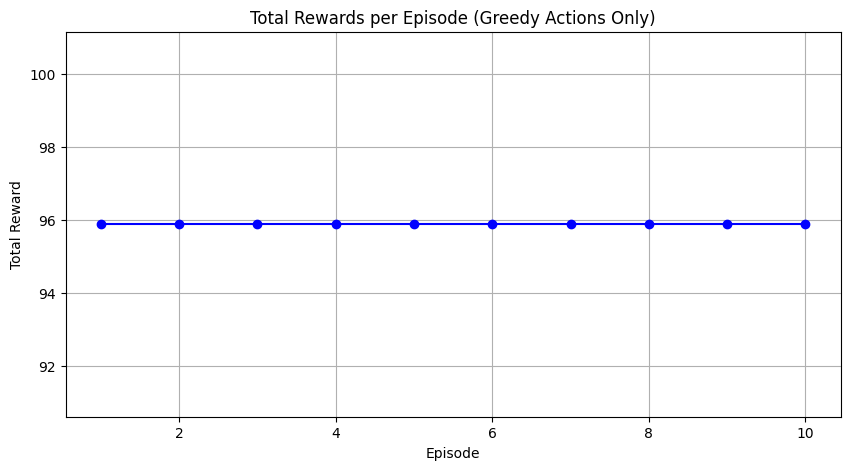

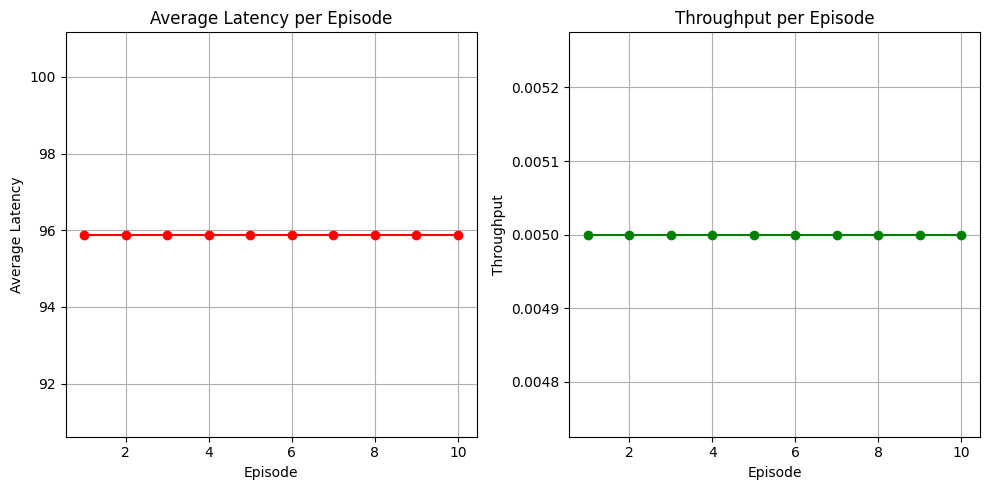

In [5]:

def evaluate(agent, env, evaluation_episodes=10, evaluation_max_steps=200):
    latencies = []
    throughput = []
    rewards = []

    # Set epsilon to 0 for greedy actions only
    agent.epsilon = 0.0

    print("\nQuantitative Evaluation Phase with Greedy Actions Only:")
    for episode in range(evaluation_episodes):
        state = env.reset()
        state_index = int(state[0]) 
        total_reward = 0
        total_latency = 0
        packet_count = 0 
        done = False

        for step in range(evaluation_max_steps):
            # Choose the action greedily
            action = np.argmax(agent.q_table[state_index].cpu().numpy() if hasattr(agent.q_table[state_index], "cpu") else agent.q_table[state_index])
            
            next_state, reward, done, _ = env.step(action)
            next_state_index = int(next_state[0])
            
            total_reward += reward
            total_latency += abs(reward) 
            packet_count += 1 if done else 0  

            state_index = next_state_index
            if done:
                break
        
        latencies.append(total_latency / packet_count if packet_count > 0 else float('inf'))
        throughput.append(packet_count / evaluation_max_steps)
        rewards.append(total_reward)

        print(f"Episode {episode + 1}/{evaluation_episodes}, Total Reward (Greedy): {total_reward:.2f}, Average Latency: {latencies[-1]:.2f}, Throughput: {throughput[-1]:.2f}")

    # Summary of results
    print("\nSummary of Quantitative Results (Greedy Actions Only):")
    print(f"Average Latency across episodes: {np.mean(latencies):.2f}")
    print(f"Average Throughput across episodes: {np.mean(throughput):.2f}")
    print(f"Average Total Reward across episodes: {np.mean(rewards):.2f}")

    # Plotting total rewards per episode
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, evaluation_episodes + 1), rewards, marker='o', color='b')
    plt.title("Total Rewards per Episode (Greedy Actions Only)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.show()

    # Plotting the average latency and throughput
    plt.figure(figsize=(10, 5))

    # Plotting the average latency per episode
    plt.subplot(1, 2, 1)
    plt.plot(range(1, evaluation_episodes + 1), latencies, marker='o', color='r')
    plt.title("Average Latency per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Latency")
    plt.grid()

    # Plotting the throughput per episode
    plt.subplot(1, 2, 2)
    plt.plot(range(1, evaluation_episodes + 1), throughput, marker='o', color='g')
    plt.title("Throughput per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Throughput")
    plt.grid()
    plt.tight_layout()
    plt.show()

evaluate(agent, env)

### SARSA

In [3]:
# As we are using Apple ARM Chips, hence ustilizing MPS 
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

class SARSA_Agent:
    def __init__(self, state_dim, action_dim, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.alpha = alpha
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = torch.zeros((state_dim, action_dim), dtype=torch.float32, device=device)  # putting the Q table on GPU 

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim) 
        else:
            return torch.argmax(self.q_table[state]).item()  

    def update_q_table(self, state, action, reward, next_state, next_action, done):
        # Updation of the Q value 
        td_target = reward + (0 if done else self.gamma * self.q_table[next_state, next_action].item())
        td_error = td_target - self.q_table[state, action].item()
        self.q_table[state, action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# SARSA Agent
def train_sarsa(env, agent, episodes=500, max_steps=200):
    episode_rewards = []
    epsilon_values = []  

    for episode in range(episodes):
        state = env.reset()
        state_idx = int(state[0] * agent.state_dim) 
        action = agent.choose_action(state_idx)

        total_reward = 0
        for step in range(max_steps):
            next_state, reward, done, _ = env.step(action)
            next_state_idx = int(next_state[0] * agent.state_dim)  
            next_action = agent.choose_action(next_state_idx)

            # Updation of the Q-table
            agent.update_q_table(state_idx, action, reward, next_state_idx, next_action, done)
            state_idx = next_state_idx
            action = next_action
            total_reward += reward

            if done:
                break

        agent.decay_epsilon()
        epsilon_values.append(agent.epsilon)  # Track epsilon after each episode
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

    return episode_rewards, epsilon_values   # returning the each episode reward and epsilon values 

# function for Plotting Results 
def results(rewards, epsilon_values):
    plt.figure(figsize=(12, 6))

    # total rewards per episode for training plot
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label="Total Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("SARSA Training Performance")
    plt.legend()
    plt.grid()

    # epsilon decay per episode for training plot 
    plt.subplot(1, 2, 2)
    plt.plot(epsilon_values, label="Epsilon Decay", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay Over Episodes")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

Episode 1/500, Total Reward: 92.50962651524665, Epsilon: 0.995
Episode 2/500, Total Reward: -47.99174491543886, Epsilon: 0.990
Episode 3/500, Total Reward: 79.0114085108841, Epsilon: 0.985
Episode 4/500, Total Reward: 92.50962651524665, Epsilon: 0.980
Episode 5/500, Total Reward: 92.50962651524665, Epsilon: 0.975
Episode 6/500, Total Reward: 68.4209662844164, Epsilon: 0.970
Episode 7/500, Total Reward: 92.50962651524665, Epsilon: 0.966
Episode 8/500, Total Reward: 92.50962651524665, Epsilon: 0.961
Episode 9/500, Total Reward: 92.50962651524665, Epsilon: 0.956
Episode 10/500, Total Reward: -23.019125627438484, Epsilon: 0.951
Episode 11/500, Total Reward: 92.50962651524665, Epsilon: 0.946
Episode 12/500, Total Reward: 53.44730789996158, Epsilon: 0.942
Episode 13/500, Total Reward: 92.50962651524665, Epsilon: 0.937
Episode 14/500, Total Reward: 37.45074949607642, Epsilon: 0.932
Episode 15/500, Total Reward: 60.526387470616314, Epsilon: 0.928
Episode 16/500, Total Reward: -23.0191256274384

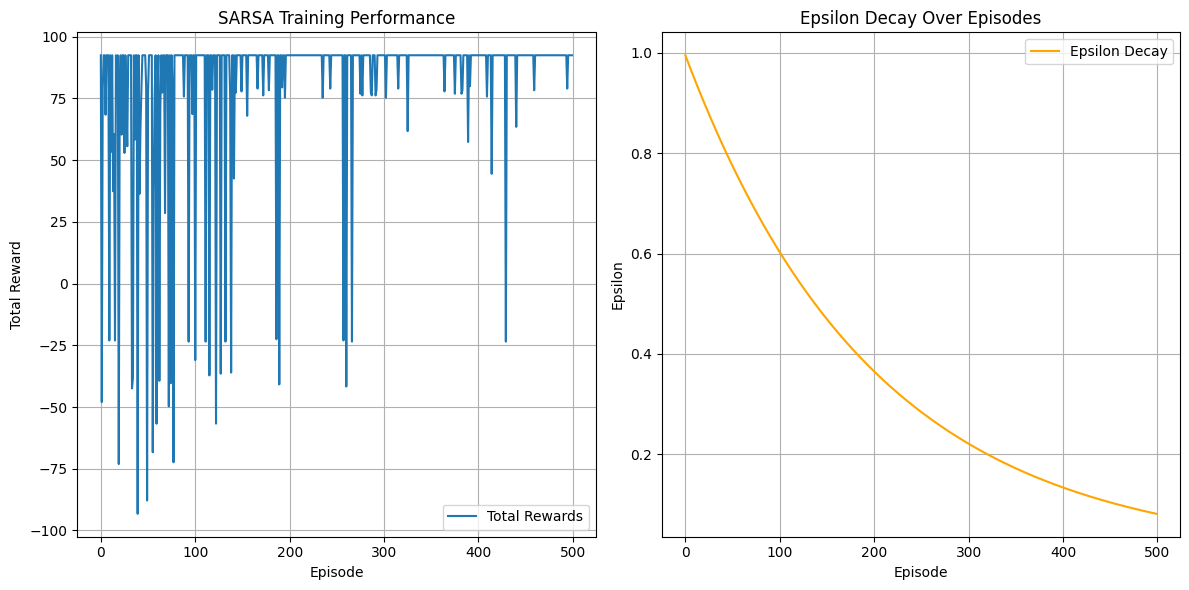

In [4]:
# Initializing the environment and the agent
data = pd.read_csv("/Users/krishnanand/Documents/Git/synthetic_network_traffic.csv")  #loding the synthetic network traffic dataset 
env = NetworkEnvironment(data) #env 
state_dim = env.num_nodes  # Number of nodes so, it will be 6 nodes 
action_dim = env.action_space.n #action(s)

agent = SARSA_Agent(state_dim=state_dim, action_dim=action_dim)

# Training the SARSA agent
rewards, epsilon_values = train_sarsa(env, agent, episodes=500)

# Plotting by calling the results function 
results(rewards, epsilon_values)

#### Single Agent - Evaluation for SARSA 


Evaluation Phase (Greedy Policy):
Episode: 1, Step: 1, State Index: 0, Action: 1, Reward: 97.47459623752273, Done: True
Episode 1/10, Total Reward: 97.47, Average Latency: 97.47, Throughput: 0.01
Episode: 2, Step: 1, State Index: 0, Action: 1, Reward: 97.47459623752273, Done: True
Episode 2/10, Total Reward: 97.47, Average Latency: 97.47, Throughput: 0.01
Episode: 3, Step: 1, State Index: 0, Action: 1, Reward: 97.47459623752273, Done: True
Episode 3/10, Total Reward: 97.47, Average Latency: 97.47, Throughput: 0.01
Episode: 4, Step: 1, State Index: 0, Action: 1, Reward: 97.47459623752273, Done: True
Episode 4/10, Total Reward: 97.47, Average Latency: 97.47, Throughput: 0.01
Episode: 5, Step: 1, State Index: 0, Action: 1, Reward: 97.47459623752273, Done: True
Episode 5/10, Total Reward: 97.47, Average Latency: 97.47, Throughput: 0.01
Episode: 6, Step: 1, State Index: 0, Action: 1, Reward: 97.47459623752273, Done: True
Episode 6/10, Total Reward: 97.47, Average Latency: 97.47, Throughput

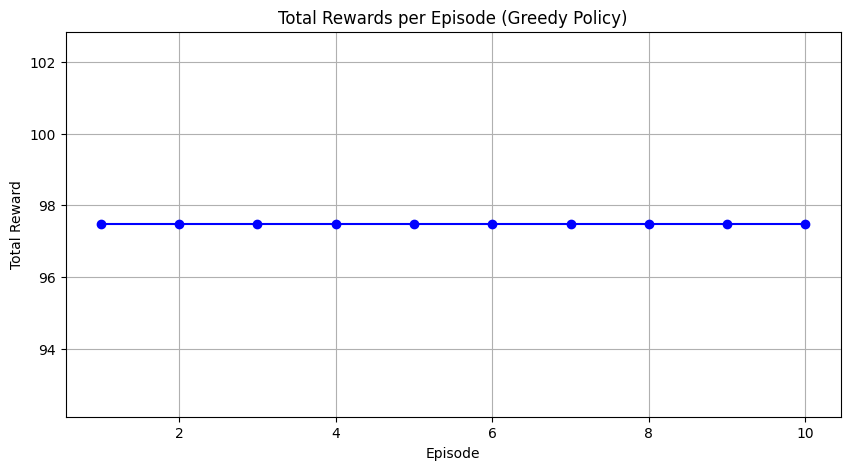

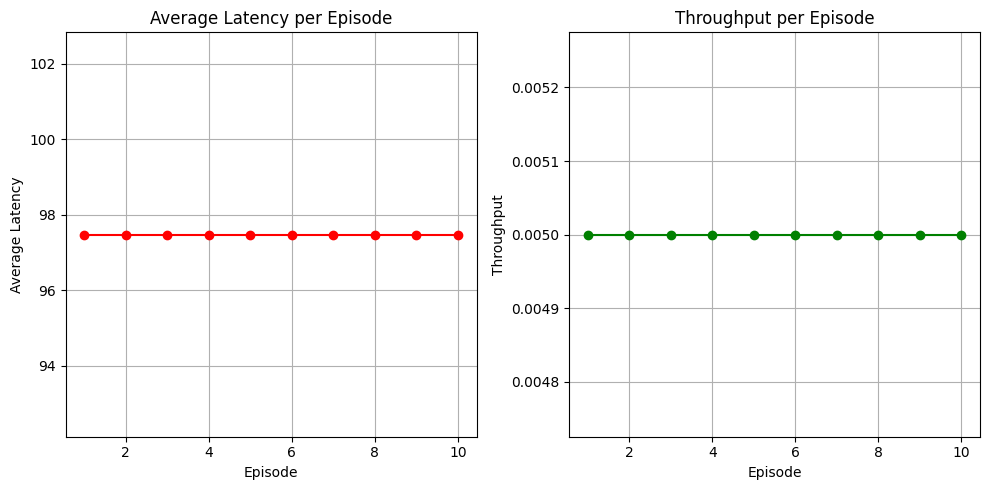

In [ ]:
def evaluate_sarsa(agent, env, evaluation_episodes=10, evaluation_max_steps=200):
    latencies = []
    throughputs = []
    rewards = []

    # Setting the epsilon to 0 for greedy policy as we dont want exploration 
    agent.epsilon = 0.0

    print("\nEvaluation Phase (Greedy Policy):")
    for episode in range(evaluation_episodes):
        state = env.reset()
        state_index = int(state[0] * agent.state_dim) 
        total_reward = 0
        total_latency = 0
        packet_count = 0

        for step in range(evaluation_max_steps):
            action = np.argmax(agent.q_table[state_index].cpu().numpy() if torch.is_tensor(agent.q_table[state_index]) else agent.q_table[state_index])

            next_state, reward, done, _ = env.step(action)
            next_state_index = int(next_state[0] * agent.state_dim)  # Map next state to discrete index

            # Printing each step information 
            print(f"Episode: {episode + 1}, Step: {step + 1}, State Index: {state_index}, Action: {action}, Reward: {reward}, Done: {done}")

            total_reward += reward
            total_latency += abs(reward)
            packet_count += 1 if done else 0

            state_index = next_state_index
            if done:
                break

        avg_latency = total_latency / packet_count if packet_count > 0 else float('inf') # caluating the latency 
        throughput = packet_count / evaluation_max_steps #calculation of throughput 

        latencies.append(avg_latency)
        throughputs.append(throughput)
        rewards.append(total_reward)

        print(f"Episode {episode + 1}/{evaluation_episodes}, Total Reward: {total_reward:.2f}, Average Latency: {avg_latency:.2f}, Throughput: {throughput:.2f}")

    print(f"Latencies: {latencies}")
    print(f"Throughputs: {throughputs}")
    print(f"Rewards: {rewards}")

    # total rewards per episode plotting 
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, evaluation_episodes + 1), rewards, marker='o', color='b')
    plt.title("Total Rewards per Episode (Greedy Policy)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    # Average latency per episode plotting 
    plt.subplot(1, 2, 1)
    plt.plot(range(1, evaluation_episodes + 1), latencies, marker='o', color='r')
    plt.title("Average Latency per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Latency")
    plt.grid()

    # Throughput per episode plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, evaluation_episodes + 1), throughputs, marker='o', color='g')
    plt.title("Throughput per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Throughput")
    plt.grid()
    plt.tight_layout()
    plt.show()

evaluate_sarsa(agent, env)

### DDQN

Using device: mps
Episode: 1/400, Total Reward: -29.64, Epsilon: 0.9950
Episode: 2/400, Total Reward: 86.52, Epsilon: 0.9900
Episode: 3/400, Total Reward: 97.00, Epsilon: 0.9851
Episode: 4/400, Total Reward: 97.00, Epsilon: 0.9801
Episode: 5/400, Total Reward: 97.00, Epsilon: 0.9752
Episode: 6/400, Total Reward: 97.00, Epsilon: 0.9704
Episode: 7/400, Total Reward: 97.00, Epsilon: 0.9655
Episode: 8/400, Total Reward: 74.86, Epsilon: 0.9607
Episode: 9/400, Total Reward: 97.00, Epsilon: 0.9559
Episode: 10/400, Total Reward: -32.53, Epsilon: 0.9511
Episode: 11/400, Total Reward: 97.00, Epsilon: 0.9464
Episode: 12/400, Total Reward: 76.39, Epsilon: 0.9416
Episode: 13/400, Total Reward: -31.77, Epsilon: 0.9369
Episode: 14/400, Total Reward: 97.00, Epsilon: 0.9322
Episode: 15/400, Total Reward: 97.00, Epsilon: 0.9276
Episode: 16/400, Total Reward: -22.99, Epsilon: 0.9229
Episode: 17/400, Total Reward: 97.00, Epsilon: 0.9183
Episode: 18/400, Total Reward: 97.00, Epsilon: 0.9137
Episode: 19/400

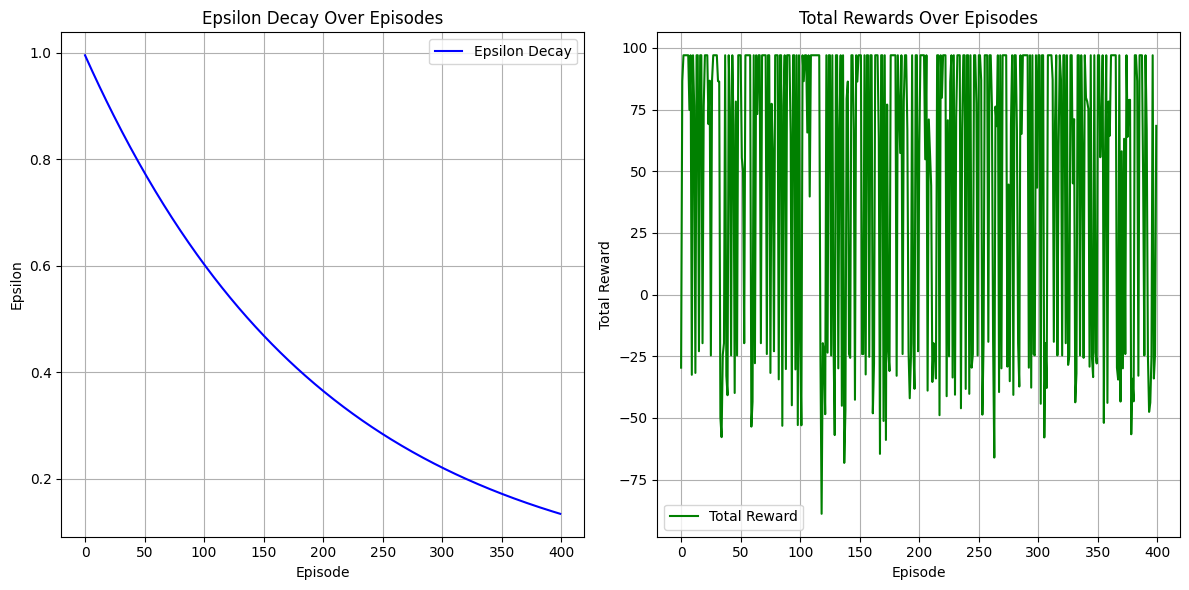

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import pandas as pd

# using MPS for faster computation 
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

class DDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=100000) 
        self.batch_size = 64

        self.model = self.built_model().to(device)
        self.target_model = self.built_model().to(device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def built_model(self):
        return nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )

    def update_target_model(self):
        # weights from the model 
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, actions, rewards, next_state, done):
        self.memory.append((state, actions, rewards, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Randomly selecting actions
            num_actions = random.randint(1, self.action_size)
            return random.sample(range(self.action_size), num_actions)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor).cpu().numpy()[0]
        num_actions = random.randint(1, self.action_size)
        return np.argsort(q_values)[-num_actions:]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, actions, rewards, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            target = self.model(state_tensor).detach()

            if done:
                for action, reward in zip(actions, rewards):
                    target[0][action] = reward
            else:
                with torch.no_grad():
                    target_action = torch.argmax(self.model(next_state_tensor)).item()
                    for action, reward in zip(actions, rewards):
                        target[0][action] = reward + self.gamma * self.target_model(next_state_tensor)[0][target_action]

            self.optimizer.zero_grad()
            output = self.model(state_tensor)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# for saving the model
def save_model(agent, file_path):
    torch.save({
        'model_state_dict': agent.model.state_dict(),
        'target_model_state_dict': agent.target_model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'epsilon': agent.epsilon
    }, file_path)
    print(f"Model saved at {file_path}")


# initializing the env and agent 
data = pd.read_csv('/Users/krishnanand/Documents/Git/synthetic_network_traffic.csv') 
env = NetworkEnvironment(data)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size)

# Defining the parameters for Training 
num_episodes = 400
log_interval = 50
save_path = "ddqn_model_final.pth"  # Save path for the final model

episode_rewards = []
epsilon_values = []

# Training DDQN agent
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        actions = agent.act(state)
        rewards = []
        for action in actions:
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_reward += reward
            if done:
                break
        agent.remember(state, actions, rewards, next_state, done)
        state = next_state

    agent.replay()
    agent.update_target_model()  # Updating the target model

    # Epsilon decay
    if len(agent.memory) < agent.batch_size and agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    episode_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)

    # printing result(s) of each step 
    print(f"Episode: {episode + 1}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

# Saving the final model
save_model(agent, save_path)

print("Training complete!")
plt.figure(figsize=(12, 6))

# epsilon decay over episode plot 
plt.subplot(1, 2, 1)
plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.grid()

# total rewards per episode for training 
plt.subplot(1, 2, 2)
plt.plot(episode_rewards, label="Total Reward", color='green')
plt.title("Total Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

#### Single Agent - Evaluation for DDQN 


Quantitative Evaluation Phase with Greedy Actions Only:
Episode 1/10, Total Reward (Greedy): -1697.42, Average Latency: 11.51, Throughput: 0.98
Episode 2/10, Total Reward (Greedy): -1885.64, Average Latency: 10.68, Throughput: 0.97
Episode 3/10, Total Reward (Greedy): -1992.01, Average Latency: 10.11, Throughput: 0.98
Episode 4/10, Total Reward (Greedy): -1784.02, Average Latency: 11.16, Throughput: 0.97
Episode 5/10, Total Reward (Greedy): -1928.96, Average Latency: 10.71, Throughput: 0.99
Episode 6/10, Total Reward (Greedy): -1789.75, Average Latency: 11.20, Throughput: 0.96
Episode 7/10, Total Reward (Greedy): -1915.28, Average Latency: 10.70, Throughput: 0.98
Episode 8/10, Total Reward (Greedy): -1480.71, Average Latency: 12.36, Throughput: 0.98
Episode 9/10, Total Reward (Greedy): -1986.11, Average Latency: 10.24, Throughput: 0.97
Episode 10/10, Total Reward (Greedy): -1603.81, Average Latency: 12.14, Throughput: 0.97

Summary of Quantitative Results (Greedy Actions Only):
Averag

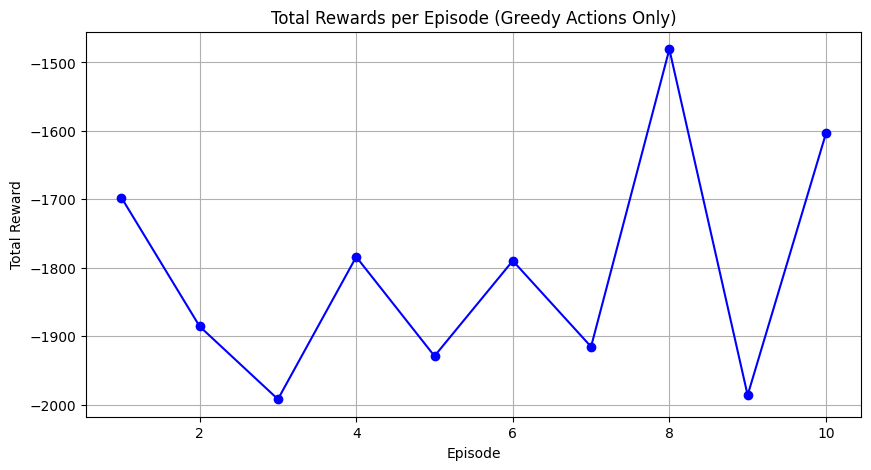

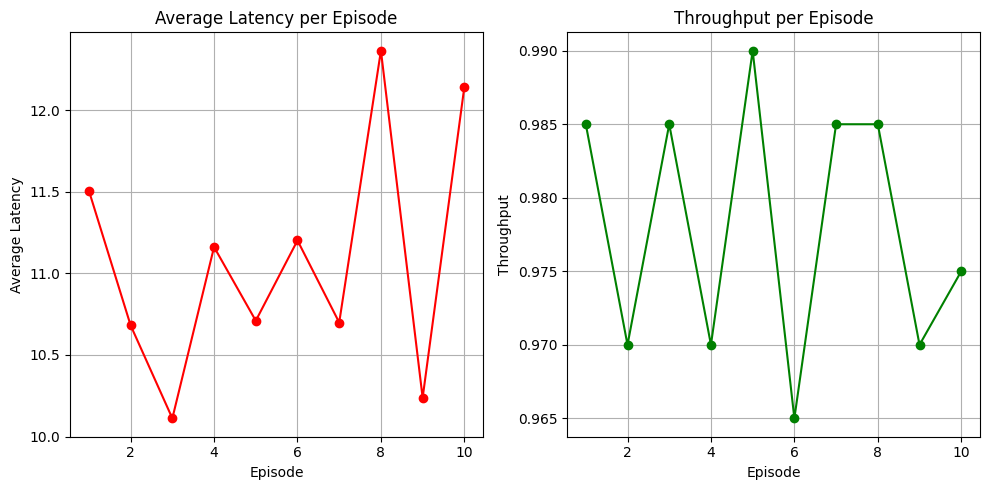

In [4]:
def evaluate(agent, env, evaluation_episodes=10, evaluation_max_steps=200):
    latencies = []
    throughput = []
    rewards = []

    # Setting the epsilon to 0 as we require greedy actions only 
    agent.epsilon = 0.0

    print("\nQuantitative Evaluation Phase with Greedy Actions Only:")
    for episode in range(evaluation_episodes):
        state = env.reset()
        state_index = int(state[0]) 
        total_reward = 0
        total_latency = 0
        packet_count = 0 
        done = False

        for step in range(evaluation_max_steps):
            actions = agent.act(state)
            for action in actions:
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                total_latency += abs(reward)
                packet_count += 1 if done else 0  
                state = next_state
                if done:
                    break

        latencies.append(total_latency / packet_count if packet_count > 0 else float('inf'))
        throughput.append(packet_count / evaluation_max_steps)
        rewards.append(total_reward)

        print(f"Episode {episode + 1}/{evaluation_episodes}, Total Reward (Greedy): {total_reward:.2f}, "
              f"Average Latency: {latencies[-1]:.2f}, Throughput: {throughput[-1]:.2f}")

    # Summary of results
    print("\nSummary of Quantitative Results (Greedy Actions Only):")
    print(f"Average Latency across episodes: {np.mean(latencies):.2f}")
    print(f"Average Throughput across episodes: {np.mean(throughput):.2f}")
    print(f"Average Total Reward across episodes: {np.mean(rewards):.2f}")

    # total rewards per episode
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, evaluation_episodes + 1), rewards, marker='o', color='b')
    plt.title("Total Rewards per Episode (Greedy Actions Only)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 5))

    # Plot average latency per episode
    plt.subplot(1, 2, 1)
    plt.plot(range(1, evaluation_episodes + 1), latencies, marker='o', color='r')
    plt.title("Average Latency per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Latency")
    plt.grid()

    # Plot throughput per episode
    plt.subplot(1, 2, 2)
    plt.plot(range(1, evaluation_episodes + 1), throughput, marker='o', color='g')
    plt.title("Throughput per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Throughput")
    plt.grid()
    plt.tight_layout()
    plt.show()

evaluate(agent, env)

### A2C

Episode 1/500, Total Reward: -20.08315507510188
Episode 2/500, Total Reward: 97.14096989571104
Episode 3/500, Total Reward: -62.835944037419324
Episode 4/500, Total Reward: -52.322823772633214
Episode 5/500, Total Reward: -60.80904270498836
Episode 6/500, Total Reward: -46.133848886197825
Episode 7/500, Total Reward: -48.863507469952644
Episode 8/500, Total Reward: -59.94421362931821
Episode 9/500, Total Reward: -55.05248235638804
Episode 10/500, Total Reward: -46.133848886197825
Episode 11/500, Total Reward: -66.86284623467935
Episode 12/500, Total Reward: -53.62006738613843
Episode 13/500, Total Reward: -67.29526077251444
Episode 14/500, Total Reward: -69.02491892385473
Episode 15/500, Total Reward: -94.94289072635712
Episode 16/500, Total Reward: -60.2414568104089
Episode 17/500, Total Reward: -36.48555769708186
Episode 18/500, Total Reward: -47.9986783942825
Episode 19/500, Total Reward: -74.78147927245504
Episode 20/500, Total Reward: -66.4304316968443
Episode 21/500, Total Reward

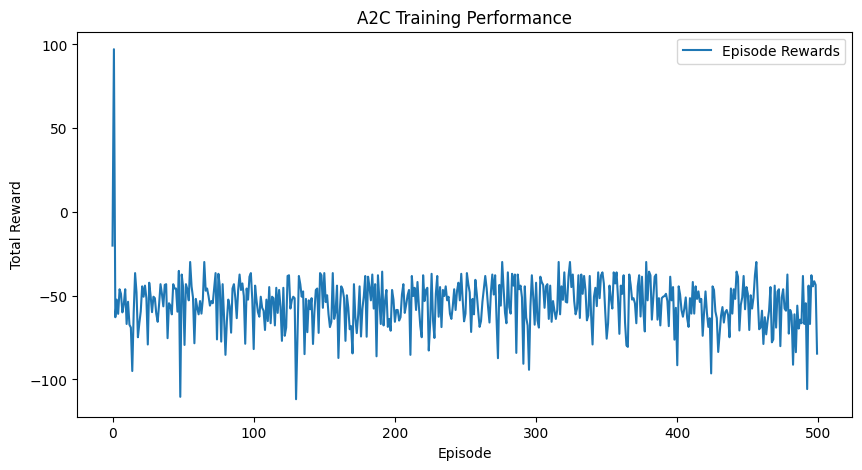

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Setting the MPS 
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the A2C Network
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNetwork, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)  # probab for actions
        )
        self.critic = nn.Linear(64, 1)  # state value(s)

    def forward(self, state):
        x = self.common(state)
        return self.actor(x), self.critic(x)

#  A2C Agent
class A2CAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.network = ActorCriticNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)

    def choose_action(self, state, greedy=False):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        probs, _ = self.network(state_tensor)
        if greedy:
            action = torch.argmax(probs).item() 
        else:
            action = torch.multinomial(probs, 1).item() 
        return action

    def returns(self, rewards, dones):
        returns = []
        G = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            G = reward + (1 - done) * self.gamma * G
            returns.insert(0, G)
        return torch.tensor(returns, dtype=torch.float32).to(device)

    def learn(self, states, actions, rewards, next_states, dones):
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device)
        returns = self.returns(rewards, dones)

        # forward pass
        probs, values = self.network(states)
        values = values.view(-1)  # Flattening of the values

        # Computing the log probabilities
        action_probs = probs.gather(1, actions.unsqueeze(-1)).squeeze(-1)
        log_probs = torch.log(action_probs + 1e-8)

        advantages = returns - values.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)  # normalization 

        actor_loss = -(log_probs * advantages).mean()
        critic_loss = nn.MSELoss()(values, returns)
        loss = actor_loss + critic_loss

        # back-prop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Save the model 
def save_model(agent, file_path):
    torch.save({
        'model_state_dict': agent.network.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict()
    }, file_path)
    print(f"Model saved at {file_path}")

# Load the model 
def load_model(agent, file_path):
    checkpoint = torch.load(file_path, map_location=device)
    agent.network.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {file_path}")

# Train agent 
def train_a2c(env, agent, episodes=500, max_steps=200):
    episode_rewards = []
    for episode in range(episodes):
        state = env.reset()
        states, actions, rewards, next_states, dones = [], [], [], [], []
        total_reward = 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

            state = next_state
            total_reward += reward

            if done:
                break
        agent.learn(states, actions, rewards, next_states, dones)

        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return episode_rewards

# Initializing the agent and the environment
data = pd.read_csv("/Users/krishnanand/Documents/Git/synthetic_network_traffic.csv")  # Replace with the correct path
env = NetworkEnvironment(data)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = A2CAgent(state_dim, action_dim)

# Training 
save_path = "a2c_model_final.pth"  # Path to save the model
rewards = train_a2c(env, agent, episodes=500)

# Saving the final model
save_model(agent, save_path)

# Plot the training results
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("A2C Training Performance")
plt.legend()
plt.show()

#### Single Agent - Evaluation for A2C 


Quantitative Evaluation Phase with Greedy Actions Only:
Episode 1/10, Total Reward (Greedy): -54.05, Average Latency: 54.05, Throughput: 0.01
Episode 2/10, Total Reward (Greedy): -80.67, Average Latency: 80.67, Throughput: 0.01
Episode 3/10, Total Reward (Greedy): -35.62, Average Latency: 35.62, Throughput: 0.01
Episode 4/10, Total Reward (Greedy): -38.65, Average Latency: 38.65, Throughput: 0.01
Episode 5/10, Total Reward (Greedy): -52.32, Average Latency: 52.32, Throughput: 0.01
Episode 6/10, Total Reward (Greedy): -35.62, Average Latency: 35.62, Throughput: 0.01
Episode 7/10, Total Reward (Greedy): -59.38, Average Latency: 59.38, Throughput: 0.01
Episode 8/10, Total Reward (Greedy): -69.89, Average Latency: 69.89, Throughput: 0.01
Episode 9/10, Total Reward (Greedy): -64.70, Average Latency: 64.70, Throughput: 0.01
Episode 10/10, Total Reward (Greedy): -68.59, Average Latency: 68.59, Throughput: 0.01

Summary of Quantitative Results (Greedy Actions Only):
Average Latency across epi

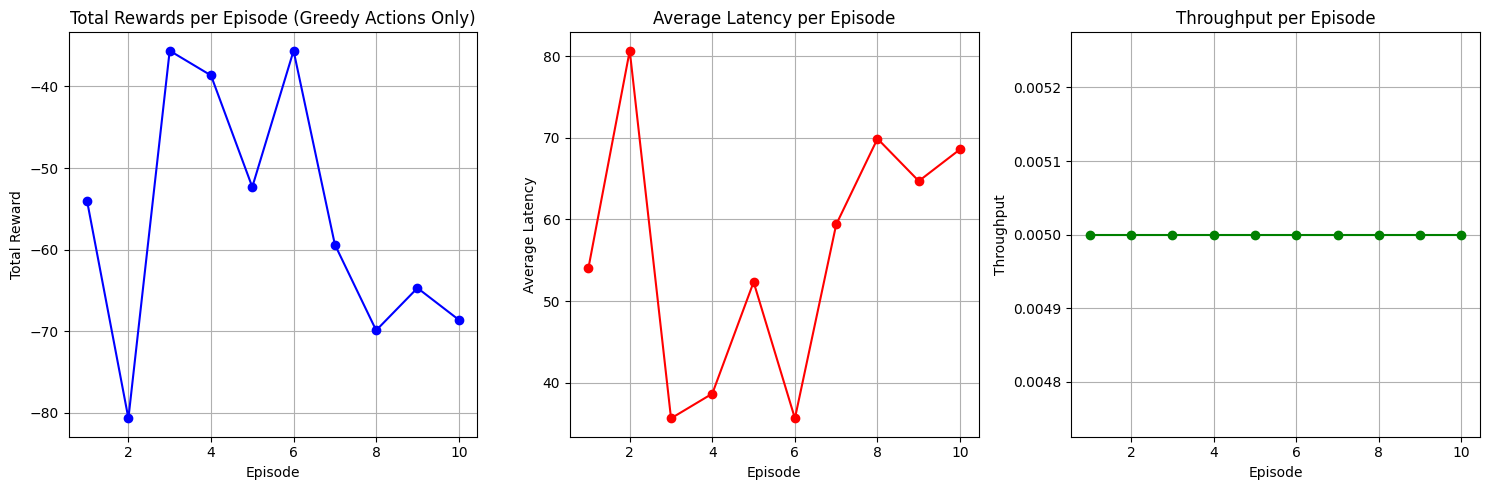

In [5]:
def evaluate(agent, env, evaluation_episodes=10, evaluation_max_steps=200):
    episode_rewards = []
    episode_latencies = []
    episode_throughputs = []

    print("\nQuantitative Evaluation Phase with Greedy Actions Only:")
    for episode in range(evaluation_episodes):
        state = env.reset()
        total_reward = 0
        total_latency = 0
        packet_count = 0 
        done = False

        for step in range(evaluation_max_steps):
            # Choosing the action(s) greedily
            action = agent.choose_action(state, greedy=True)
            next_state, reward, done, _ = env.step(action)
            
            total_reward += reward
            total_latency += abs(reward) 
            if done:
                packet_count += 1
            
            state = next_state 

            if done:
                break

        average_latency = total_latency / packet_count if packet_count > 0 else float('inf') #calculating the avg latency
        throughput = packet_count / evaluation_max_steps # computing the throughput

        episode_rewards.append(total_reward)
        episode_latencies.append(average_latency)
        episode_throughputs.append(throughput)

        print(f"Episode {episode + 1}/{evaluation_episodes}, Total Reward (Greedy): {total_reward:.2f}, "
              f"Average Latency: {average_latency:.2f}, Throughput: {throughput:.2f}")

    # Summary of results
    avg_reward = np.mean(episode_rewards)
    avg_latency = np.mean(episode_latencies)
    avg_throughput = np.mean(episode_throughputs)

    print("\nSummary of Quantitative Results (Greedy Actions Only):")
    print(f"Average Latency across episodes: {avg_latency:.2f}")
    print(f"Average Throughput across episodes: {avg_throughput:.2f}")
    print(f"Average Total Reward across episodes: {avg_reward:.2f}")

    # total rewards per episode plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, evaluation_episodes + 1), episode_rewards, marker='o', color='b')
    plt.title("Total Rewards per Episode (Greedy Actions Only)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()

    # average latency per episode plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, evaluation_episodes + 1), episode_latencies, marker='o', color='r')
    plt.title("Average Latency per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Latency")
    plt.grid()

    # throughput per episode plot
    plt.subplot(1, 3, 3)
    plt.plot(range(1, evaluation_episodes + 1), episode_throughputs, marker='o', color='g')
    plt.title("Throughput per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Throughput")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "episode_rewards": episode_rewards,
        "episode_latencies": episode_latencies,
        "episode_throughputs": episode_throughputs,
        "avg_reward": avg_reward,
        "avg_latency": avg_latency,
        "avg_throughput": avg_throughput
    }

# Evaluation 
evaluation_results = evaluate(agent, env)